In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from arch import arch_model
from sklearn.metrics import mean_absolute_error
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [21]:
ticker = yf.Ticker("NVDA")
print(ticker)
data = yf.download('NVDA', start='2015-01-01', end='2025-01-01')

data.head()


[*********************100%***********************]  1 of 1 completed

yfinance.Ticker object <NVDA>


Price,Close,High,Low,Open,Volume
Ticker,NVDA,NVDA,NVDA,NVDA,NVDA
Date,,,,,
2015-01-02,0.483144,0.486744,0.475463,0.483144,113680000
2015-01-05,0.474983,0.484584,0.472823,0.483144,197952000
2015-01-06,0.460582,0.476183,0.460102,0.475703,197764000
2015-01-07,0.459382,0.468023,0.457942,0.463943,321808000
2015-01-08,0.476663,0.479543,0.464423,0.464663,283780000


In [22]:
data.index = pd.to_datetime(data.index)  #data from yfinance provides a DatetimeIndex, but not automatically assign a frequency ( which what statsmodels expect)
data = data.asfreq('B')
print(data.index.freq)


<BusinessDay>


In [23]:
ticker.info['currency']

'USD'

In [24]:
print(data.isnull().sum())


Price   Ticker
Close   NVDA      92
High    NVDA      92
Low     NVDA      92
Open    NVDA      92
Volume  NVDA      92
dtype: int64


In [25]:
data = data[['Close']]
data.rename(columns={'Close': 'Price'}, inplace=True)


### Visualizing trends, seasonality, and volatility

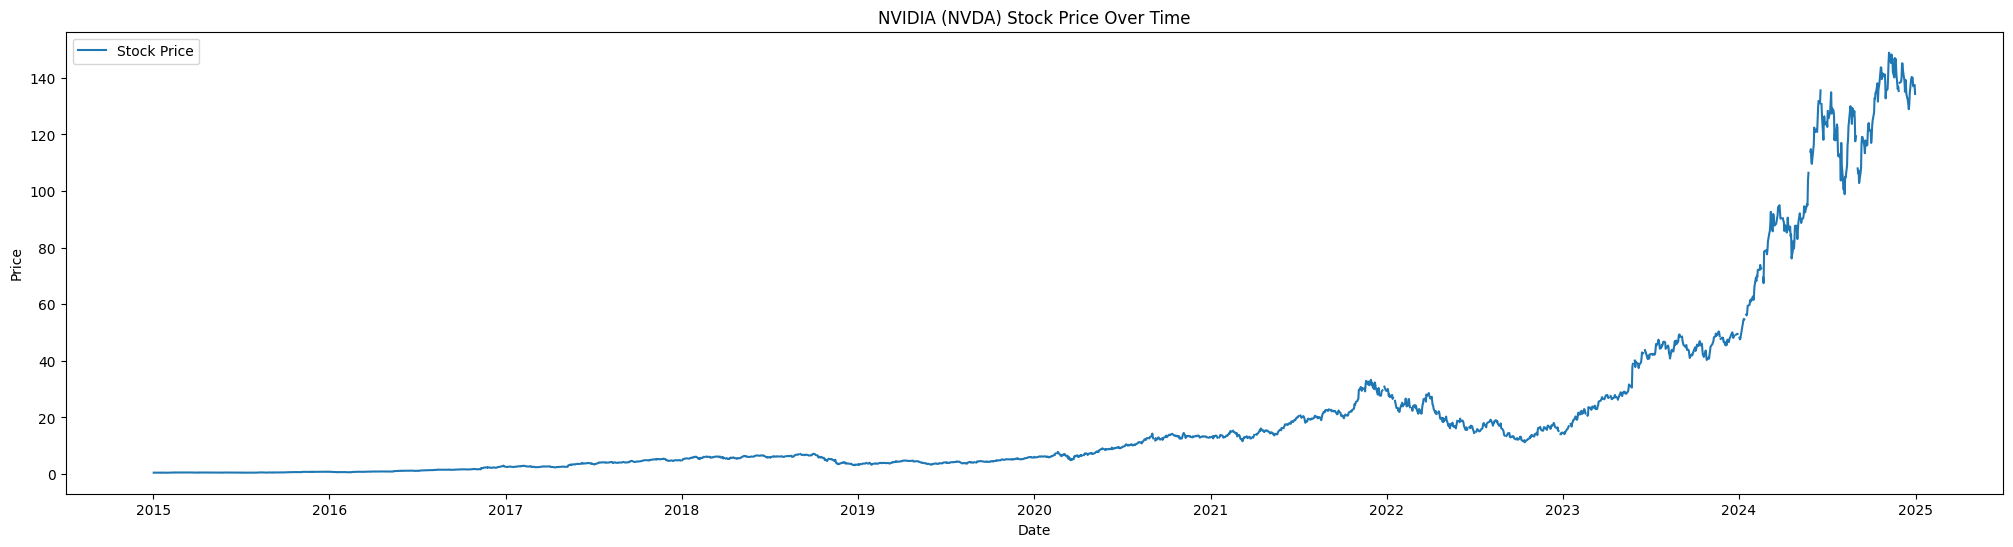

In [26]:
plt.figure(figsize=(25,6))
plt.plot(data['Price'], label='Stock Price')
plt.title('NVIDIA (NVDA) Stock Price Over Time')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()


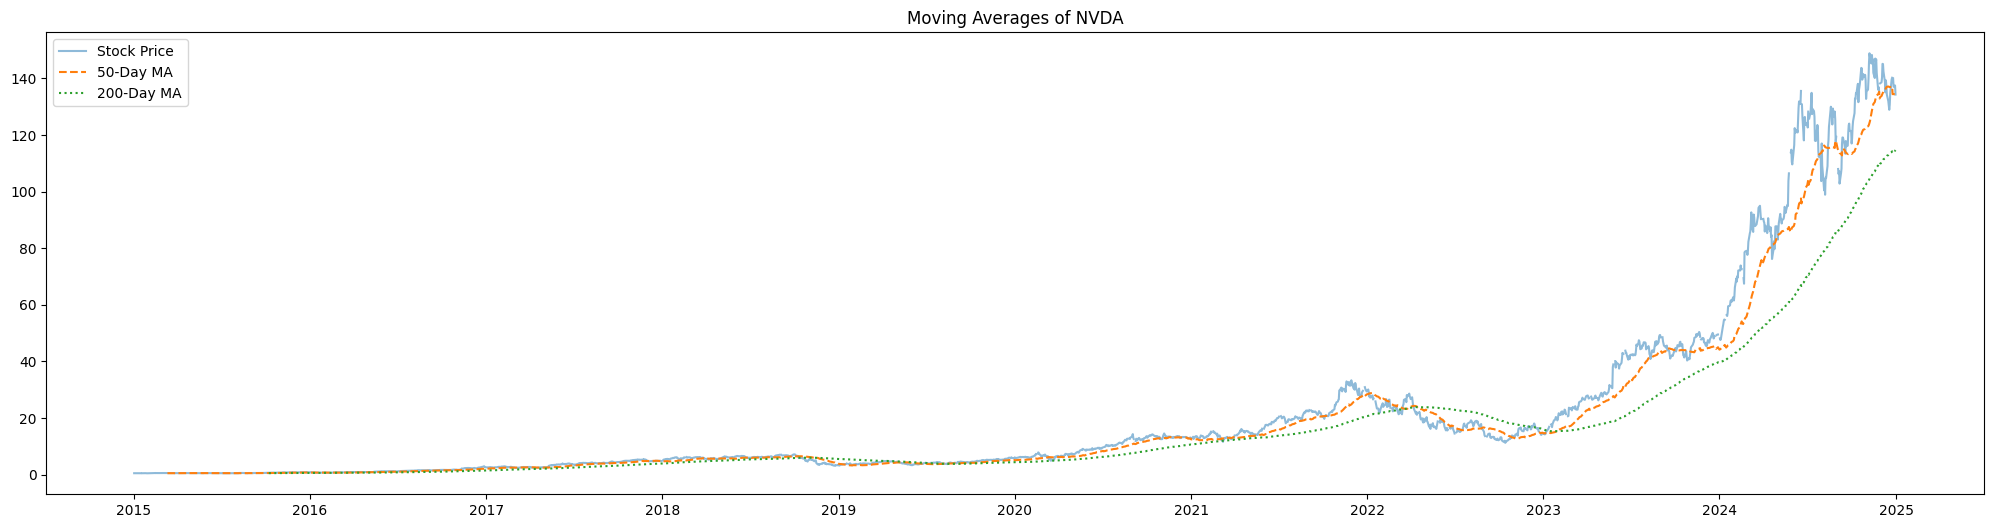

In [27]:
#trend smoothing
data_50_MA = data['Price'].fillna(0).rolling(window=50).mean()  # 50-day moving average
data_200_MA = data['Price'].fillna(0).rolling(window=200).mean()  # 200-day moving average

plt.figure(figsize=(25,6))
plt.plot(data['Price'], label='Stock Price', alpha=0.5)
plt.plot(data_50_MA, label='50-Day MA', linestyle='dashed')
plt.plot(data_200_MA, label='200-Day MA', linestyle='dotted')
plt.title('Moving Averages of NVDA')
plt.legend()
plt.show()


* upward momentum since 2023
* 50-day MA crossed above the 200-day MA (Golden Cross) -> bullish

In [28]:
data['Price']= data['Price'].fillna(method='ffill')

<Figure size 640x480 with 0 Axes>

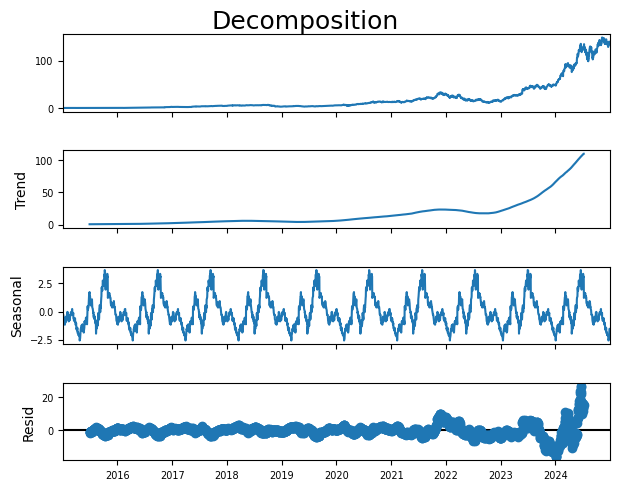

In [29]:
plt.figure()  
decomposition = seasonal_decompose(data['Price'], model='additive', period=252)

decomposition.plot()
plt.suptitle("Decomposition", fontsize=18, y=1.02)  
plt.subplots_adjust(hspace=0.5)  

for ax in plt.gcf().axes:
    ax.tick_params(axis='both', labelsize=7) 
    ax.title.set_fontsize(4)  

plt.show()


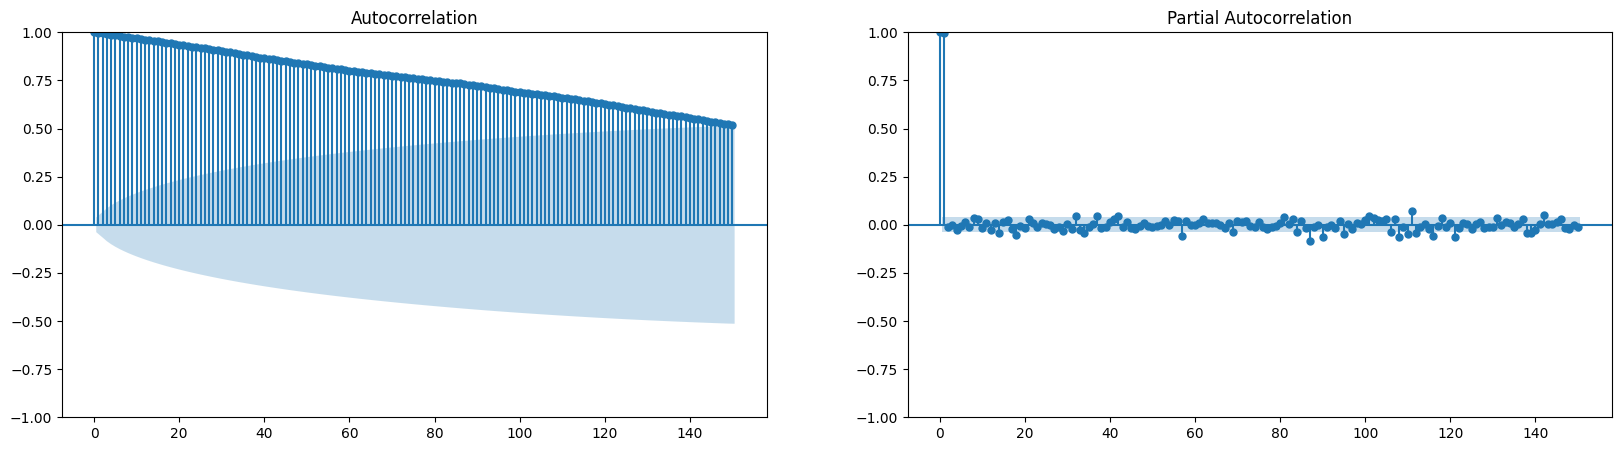

In [30]:
fig, ax = plt.subplots(1,2, figsize=(20,5))
plot_acf(data['Price'], lags=150, ax=ax[0])  #Autocorrelation
plot_pacf(data['Price'], lags=150, ax=ax[1])  #Partial Autocorrelation
plt.show()

* PACF suggest p=2 (2 lags out of confidence interval)

### Stationarity tests
*  Augmented Dickey-Fuller (ADF) 
*  Kwiatkowski-Phillips-Schmidt-Shin (KPSS)

In [31]:
def adf_test(series):
    result = adfuller(series)
    print(f'ADF Statistic: {result[0]}')
    print(f'p-value: {result[1]}')
    if result[1] <= 0.05:
        print("The series is stationary.")
    else:
        print("The series is not stationary.")

adf_test(data['Price'])

ADF Statistic: 2.8525570140078766
p-value: 1.0
The series is not stationary.


In [32]:
data['Price_diff']= data['Price'].diff()

data['Price_diff']

Date
2015-01-02         NaN
2015-01-05   -0.008160
2015-01-06   -0.014401
2015-01-07   -0.001200
2015-01-08    0.017281
                ...   
2024-12-25    0.000000
2024-12-26   -0.290009
2024-12-27   -2.919998
2024-12-30    0.480011
2024-12-31   -3.200012
Freq: B, Name: Price_diff, Length: 2608, dtype: float64

In [33]:
data['Price_diff'] = data['Price_diff'].fillna(method='Bfill')


In [34]:
data['Price_diff'] 

Date
2015-01-02   -0.008160
2015-01-05   -0.008160
2015-01-06   -0.014401
2015-01-07   -0.001200
2015-01-08    0.017281
                ...   
2024-12-25    0.000000
2024-12-26   -0.290009
2024-12-27   -2.919998
2024-12-30    0.480011
2024-12-31   -3.200012
Freq: B, Name: Price_diff, Length: 2608, dtype: float64

In [35]:
adf_test(data['Price_diff'])

ADF Statistic: -9.763596534977514
p-value: 7.450535764316304e-17
The series is stationary.


* stationary after one differenciation (d=1)

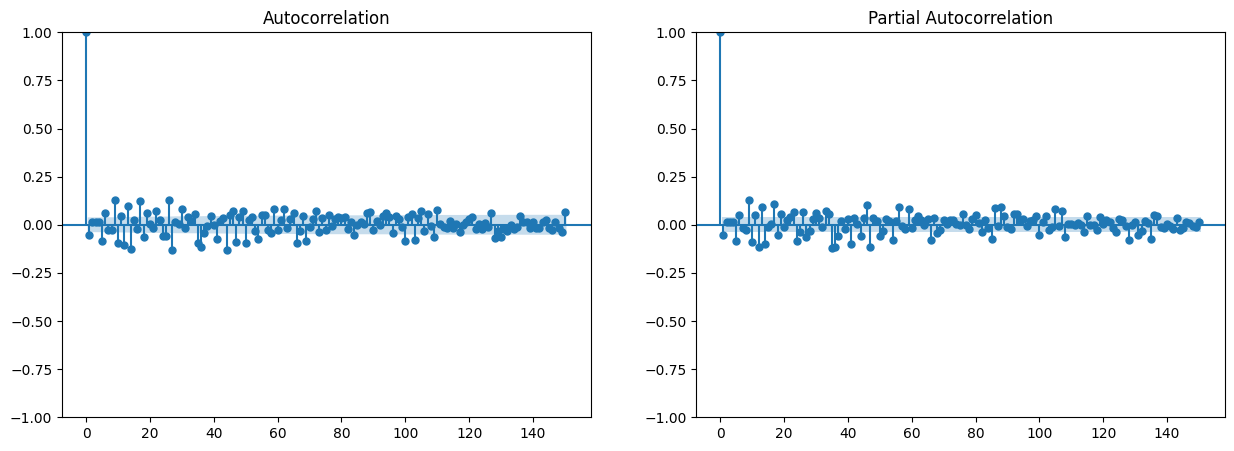

In [36]:
fig, ax = plt.subplots(1,2, figsize=(15,5))
plot_acf(data['Price_diff'].dropna(), lags=150, ax=ax[0]) 
plot_pacf(data['Price_diff'].dropna(), lags=150, ax=ax[1])  
plt.show()

In [37]:
ts = data['Price_diff']

* AIC: Focuses on goodness-of-fit but penalizes model complexity (more params)
$$
\text{AIC} = 2k - 2\ln(\hat{L})
$$
* BIC: Similar to AIC but penalizes complexity more heavily than AIC
$$
\text{BIC} = k \ln(n) - 2\ln(\hat{L})
$$
&rarr; Lower values of AIC and BIC indicate a better fit, with a trade-off between model complexity and goodness-of-fit

In [38]:
model_010 = ARIMA(ts, order=(0, 1, 0)).fit()
model_110 = ARIMA(ts, order=(1, 1, 0)).fit()
model_011 = ARIMA(ts, order=(0, 1, 1)).fit()
model_111 = ARIMA(ts, order=(1, 1, 1)).fit()


print(model_010.summary())
print(model_110.summary())
print(model_011.summary())
print(model_111.summary())

# Comparing AIC/BIC values
print("AIC values:")
print("ARIMA(0, 1, 0):", model_010.aic)
print("ARIMA(1, 1, 0):", model_110.aic)
print("ARIMA(0, 1, 1):", model_011.aic)
print("ARIMA(1, 1, 1):", model_111.aic)

print("BIC values:")
print("ARIMA(0, 1, 0):", model_010.bic)
print("ARIMA(1, 1, 0):", model_110.bic)
print("ARIMA(0, 1, 1):", model_011.bic)
print("ARIMA(1, 1, 1):", model_111.bic)

                               SARIMAX Results                                
Dep. Variable:             Price_diff   No. Observations:                 2608
Model:                 ARIMA(0, 1, 0)   Log Likelihood               -5104.461
Date:                Sun, 09 Feb 2025   AIC                          10210.923
Time:                        18:01:39   BIC                          10216.789
Sample:                    01-02-2015   HQIC                         10213.048
                         - 12-31-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         2.9390      0.019    153.223      0.000       2.901       2.977
Ljung-Box (L1) (Q):                 741.20   Jarque-Bera (JB):            125998.75
Prob(Q):                              0.00   Pr

### Seasonal adjustments

In [39]:
data['Price']

Ticker,NVDA
Date,
2015-01-02,0.483144
2015-01-05,0.474983
2015-01-06,0.460582
2015-01-07,0.459382
2015-01-08,0.476663
...,...
2024-12-25,140.220001
2024-12-26,139.929993
2024-12-27,137.009995


In [40]:
data['Price_seasonal_diff'] = data['Price'] - data['Price'].shift(252)
data['Price_seasonal_diff'].dropna(inplace=True)

/var/folders/cw/0t2jzw0d1dg1rj3qj57z9_qh0000gn/T/ipykernel_23026/27316682.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Price_seasonal_diff'].dropna(inplace=True)


In [41]:
# Seasonal differencing
adfuller(data['Price_seasonal_diff'].dropna())


(0.8212578860660001,
 0.9919716752800564,
 27,
 2328,
 {'1%': -3.433162081244742,
  '5%': -2.8627823222150104,
  '10%': -2.567431343047732},
 7730.779237772385)

In [42]:
adf_test(data['Price_seasonal_diff'].dropna())

ADF Statistic: 0.8212578860660001
p-value: 0.9919716752800564
The series is not stationary.


In [43]:
data['Price_diff_full'] = data['Price_seasonal_diff'] - data['Price_seasonal_diff'].shift(1)
adf_test(data['Price_diff_full'].dropna())


ADF Statistic: -9.526579448377431
p-value: 2.9667294853768283e-16
The series is stationary.


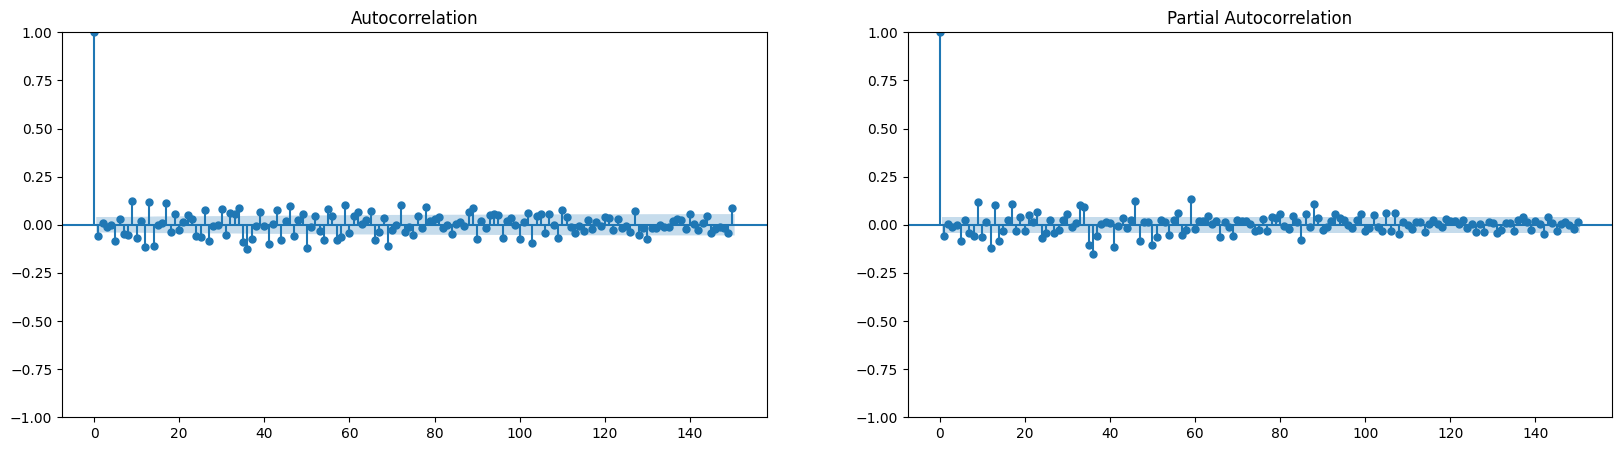

In [44]:
fig, ax = plt.subplots(1,2, figsize=(20,5))

plot_acf(data['Price_diff_full'].dropna(), lags=150, ax=ax[0])
plot_pacf(data['Price_diff_full'].dropna(), lags=150, ax=ax[1])

plt.show()

In [45]:
print(data['Price'].isnull().sum())


Ticker
NVDA    0
dtype: int64


In [46]:
help(SARIMAX)

Help on class SARIMAX in module statsmodels.tsa.statespace.sarimax:

class SARIMAX(statsmodels.tsa.statespace.mlemodel.MLEModel)
 |  SARIMAX(endog, exog=None, order=(1, 0, 0), seasonal_order=(0, 0, 0, 0), trend=None, measurement_error=False, time_varying_regression=False, mle_regression=True, simple_differencing=False, enforce_stationarity=True, enforce_invertibility=True, hamilton_representation=False, concentrate_scale=False, trend_offset=1, use_exact_diffuse=False, dates=None, freq=None, missing='none', validate_specification=True, **kwargs)
 |  
 |  Seasonal AutoRegressive Integrated Moving Average with eXogenous regressors
 |  model
 |  
 |  Parameters
 |  ----------
 |  endog : array_like
 |      The observed time-series process :math:`y`
 |  exog : array_like, optional
 |      Array of exogenous regressors, shaped nobs x k.
 |  order : iterable or iterable of iterables, optional
 |      The (p,d,q) order of the model for the number of AR parameters,
 |      differences, and MA p

In [28]:
# sarima_model = SARIMAX(data['Price'][-1260:], #last 5yrs of trading days
#                        order=(1, 1, 1),          # Non-seasonal (p, d, q)
#                        seasonal_order=(1, 1, 1, 252),  # Seasonal (P, D, Q, s)
#                        enforce_stationarity=False, 
#                        enforce_invertibility=False,
                       
# )

# sarima_result = sarima_model.fit()
# print(sarima_result.summary())

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.76610D+01    |proj g|=  2.98605D-01
  ys=-5.120E+01  -gs= 5.908E-01 BFGS update SKIPPED


KeyboardInterrupt: 

In [ ]:
# residuals = sarima_result.resid

# plot_acf(residuals.dropna(), lags=50)
# plt.title("ACF of SARIMA Residuals")
# plt.show()

###  Modeling Volatility clustering

**ARCH(q)** :

$$
\sigma_t^2 = \alpha_0 + \alpha_1 \epsilon_{t-1}^2 + \alpha_2 \epsilon_{t-2}^2 + \dots + \alpha_q \epsilon_{t-q}^2
$$


- $\sigma_t^2$: Conditional variance at time $t$.
- $\epsilon_t$: Residuals or error terms at time $t$.


**GARCH(p, q)**:

$$
\sigma_t^2 = \alpha_0 + \sum_{i=1}^q \alpha_i \epsilon_{t-i}^2 + \sum_{j=1}^p \beta_j \sigma_{t-j}^2
$$

With:
- $\sigma_{t-j}^2$: lagged variances (GARCH terms).




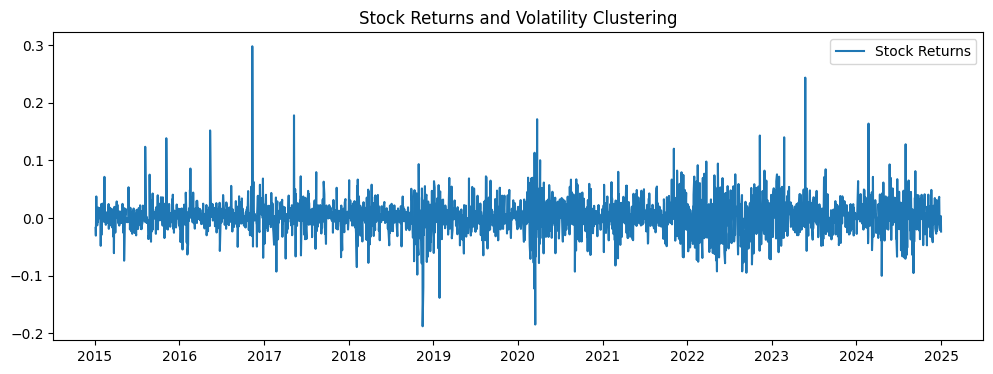

In [54]:
data['Returns'] = data['Price'].pct_change().dropna()
plt.figure(figsize=(12, 4))
plt.plot(data['Returns'], label='Stock Returns')
plt.title('Stock Returns and Volatility Clustering')
plt.legend()
plt.show()

In [55]:
arch_model_1 = arch_model(data['Returns'].dropna(), vol='ARCH', p=1)
arch_result = arch_model_1.fit()
print(arch_result.summary())


Iteration:      1,   Func. Count:      5,   Neg. LLF: 386422902.18339497
Iteration:      2,   Func. Count:     16,   Neg. LLF: -3507.8025597095975
Iteration:      3,   Func. Count:     23,   Neg. LLF: -5301.643636025813
Iteration:      4,   Func. Count:     29,   Neg. LLF: -3050.7249663621833
Iteration:      5,   Func. Count:     36,   Neg. LLF: -5488.090029386074
Iteration:      6,   Func. Count:     41,   Neg. LLF: -5488.0931046846235
Iteration:      7,   Func. Count:     45,   Neg. LLF: -5488.093106632185
Iteration:      8,   Func. Count:     48,   Neg. LLF: -5488.093106632181
Optimization terminated successfully    (Exit mode 0)
            Current function value: -5488.093106632185
            Iterations: 8
            Function evaluations: 48
            Gradient evaluations: 8
                      Constant Mean - ARCH Model Results                      
Dep. Variable:                Returns   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-

/Users/grace/miniconda3/envs/tf/lib/python3.10/site-packages/arch/univariate/base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0009044. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


In [57]:
garch_model = arch_model(data['Returns'].fillna(0), vol='Garch', p=1, q=1)
garch_result = garch_model.fit()
print(garch_result.summary())

Iteration:      1,   Func. Count:      6,   Neg. LLF: 12330098825.863405
Iteration:      2,   Func. Count:     18,   Neg. LLF: 9054.268433086896
Iteration:      3,   Func. Count:     29,   Neg. LLF: -649.9393159507076
Iteration:      4,   Func. Count:     38,   Neg. LLF: 1272.82147721123
Iteration:      5,   Func. Count:     47,   Neg. LLF: -5074.95722403027
Iteration:      6,   Func. Count:     54,   Neg. LLF: -5105.792939720106
Iteration:      7,   Func. Count:     62,   Neg. LLF: -5494.979801523408
Iteration:      8,   Func. Count:     69,   Neg. LLF: -5537.320482357798
Iteration:      9,   Func. Count:     75,   Neg. LLF: -5555.01753198514
Iteration:     10,   Func. Count:     80,   Neg. LLF: -5555.017554683592
Iteration:     11,   Func. Count:     85,   Neg. LLF: -5555.017551552382
Optimization terminated successfully    (Exit mode 0)
            Current function value: -5555.017554683589
            Iterations: 11
            Function evaluations: 95
            Gradient evaluati

/Users/grace/miniconda3/envs/tf/lib/python3.10/site-packages/arch/univariate/base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.000904. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(



 
> - **β₁ = 0.7888**: The past variance contributes about 79% to the current conditional variance.
> - **α₁ = 0.1886**: Recent squared residuals contribute about 19% to the current conditional variance.
> 
> &rarr; **After Rescaling**:  
> After rescaling Coefficients have **larger absolute values** but still sum to a value close to 1 (**0.9774**), indicating the same **volatility persistence** (regardless of direction or magnitude).


In [75]:
data['Returns_scaled'] = data['Returns'] * 100
garch_model = arch_model(data['Returns_scaled'].dropna(), vol='Garch', p=1, q=1)
garch_result = garch_model.fit()

Iteration:      1,   Func. Count:      6,   Neg. LLF: 12684.202642439403
Iteration:      2,   Func. Count:     14,   Neg. LLF: 4389178.495005142
Iteration:      3,   Func. Count:     21,   Neg. LLF: 6888.242152820341
Iteration:      4,   Func. Count:     28,   Neg. LLF: 6509.042200431913
Iteration:      5,   Func. Count:     35,   Neg. LLF: 6862.995201837404
Iteration:      6,   Func. Count:     42,   Neg. LLF: 6453.616362569161
Iteration:      7,   Func. Count:     47,   Neg. LLF: 6453.616359584925
Iteration:      8,   Func. Count:     51,   Neg. LLF: 6453.616359585007
Optimization terminated successfully    (Exit mode 0)
            Current function value: 6453.616359584925
            Iterations: 8
            Function evaluations: 51
            Gradient evaluations: 8


In [79]:
print(garch_result.summary())

                     Constant Mean - GARCH Model Results                      
Dep. Variable:         Returns_scaled   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -6453.62
Distribution:                  Normal   AIC:                           12915.2
Method:            Maximum Likelihood   BIC:                           12938.7
                                        No. Observations:                 2607
Date:                Sun, Feb 09 2025   Df Residuals:                     2606
Time:                        18:09:54   Df Model:                            1
                               Mean Model                               
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu             0.3545  7.049e-02      5.028  4.948e-07 [  0.216,  0.49

In [76]:
residuals = garch_result.resid

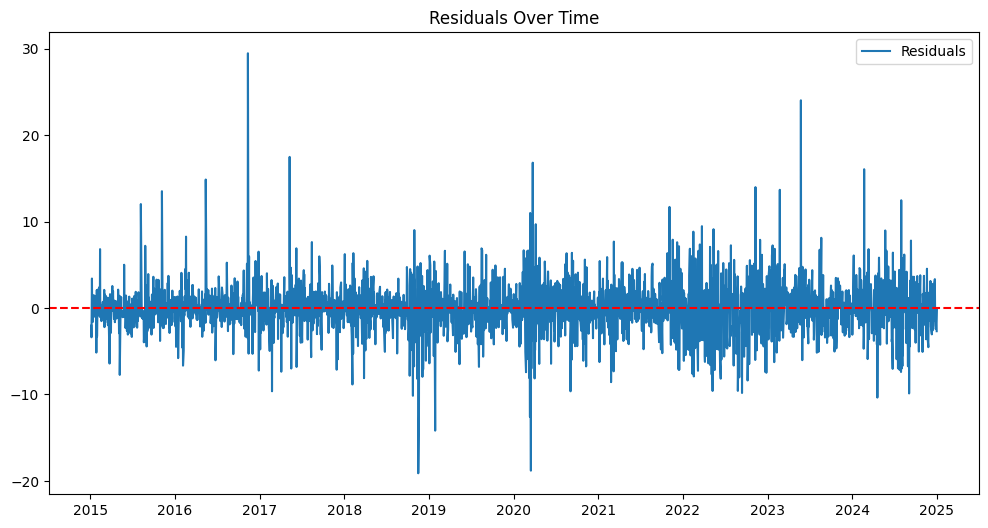

In [81]:
plt.figure(figsize=(12, 6))
plt.plot(residuals, label='Residuals')
plt.axhline(0, color='red', linestyle='--')
plt.title('Residuals Over Time')
plt.legend()
plt.show()

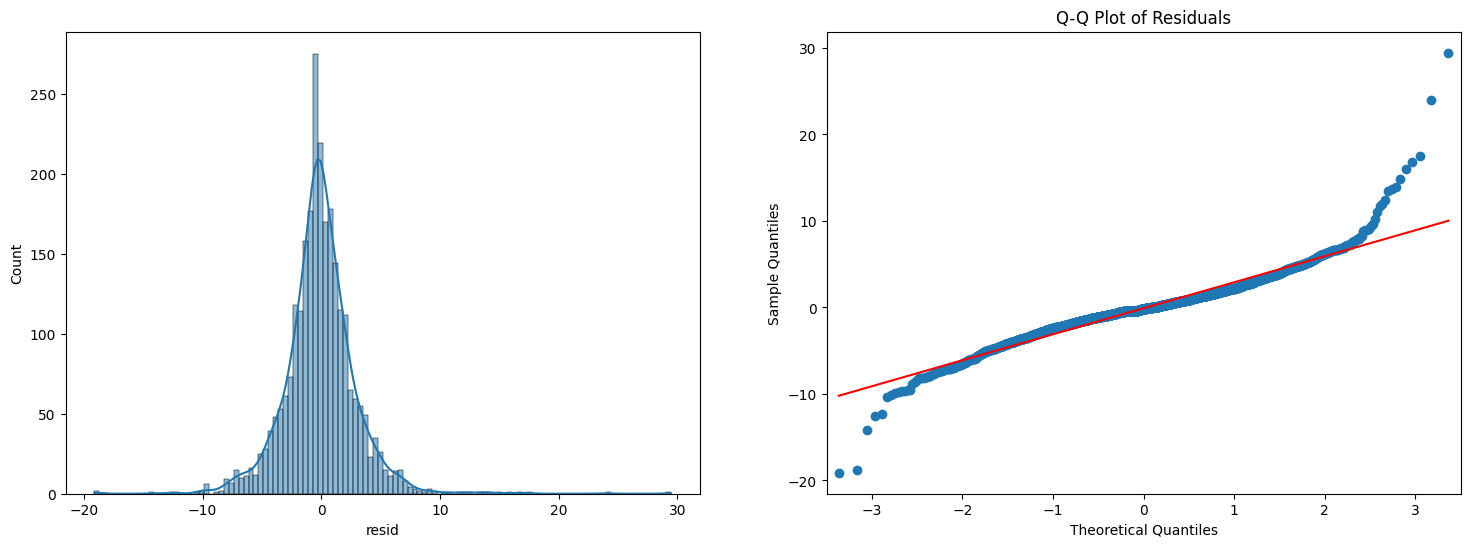

In [78]:
import statsmodels.api as sm
import seaborn as sns

fig, ax = plt.subplots(1,2, figsize=(18,6))
sns.histplot(residuals, kde=True, ax=ax[0])
sm.qqplot(residuals, line='s', ax=ax[1])
plt.title('Q-Q Plot of Residuals')
plt.show()